# 0.4.0 Customer Segmentation with K-means

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append("../") 

import utils.paths as path
from utils.paths2 import direcciones

## 0.4.2 Run k-means

In [4]:
datamart_normalized_df = pd.read_csv(path.data_raw_dir("datamart_normalized_df.csv"), sep=',', index_col='CustomerID')
datamart_normalized = datamart_normalized_df.to_numpy()
datamart_normalized

array([[-2.00220213,  0.865157  ,  1.4649405 ],
       [-2.81451782,  3.81527235,  2.99469233],
       [-1.78948954,  1.18911731,  1.34759823],
       ...,
       [-1.27697541, -1.22195523, -1.15248482],
       [-1.78948954,  2.35670574,  0.86642248],
       [-0.03348042,  0.44304102,  0.79793723]])

In [5]:
# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

## 0.4.3 Assign labels to raw data

In [6]:
datamart_rfm = pd.read_csv(path.data_raw_dir("rfm_datamart.csv"), sep=',', index_col='CustomerID')
datamart_rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,3,25,948.70
12748,1,888,7046.16
12749,4,37,813.45
12820,4,17,268.02
12822,71,9,146.15


In [7]:
# Create a DataFrame by adding a new cluster label column
datamart_rfm_k3 = datamart_rfm.assign(Cluster=cluster_labels)
datamart_rfm_k3.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12747,3,25,948.70,0
12748,1,888,7046.16,0
12749,4,37,813.45,0
12820,4,17,268.02,0
12822,71,9,146.15,2


In [8]:
# Group the data by cluster
grouped = datamart_rfm_k3.groupby(['Cluster'])
# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          16.1      50.1        1050.6   901
1         166.6       3.0          53.0  1156
2          77.1      12.3         216.0  1586

## 0.4.5 Calculate sum of squared errors

In [9]:
data = pd.read_csv(path.data_raw_dir("data3.csv"), sep=',')

# Unskew the data
datamart_log = np.log(data)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(datamart_log)

# Scale and center the data
datamart_normalized = scaler.transform(datamart_log)

# Create a pandas DataFrame
datamart_normalized = pd.DataFrame(datamart_normalized, index=data.index, columns=data.columns)

In [10]:
sse = {}

# Fit KMeans and calculate SSE for each k
for k in range(1, 15):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(datamart_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

## 0.4.6 Plot sum of squared errors

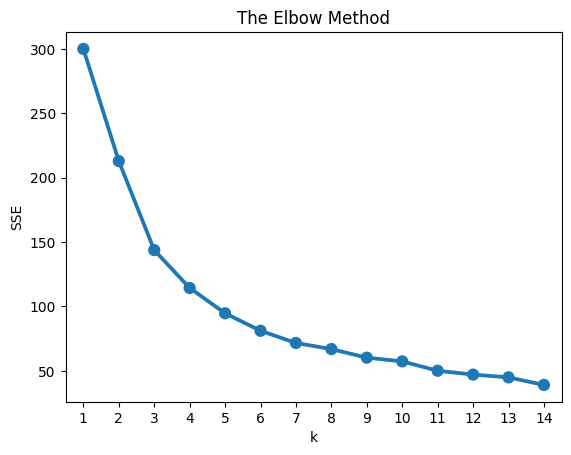

In [11]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

## 0.4.8 Prepare data for the snake plot

In [12]:
# Unskew the data
datamart_log = np.log(datamart_rfm)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(datamart_log)

# Scale and center the data
datamart_normalized = scaler.transform(datamart_log)

# Create a pandas DataFrame
datamart_normalized = pd.DataFrame(datamart_normalized, index=datamart_rfm.index, columns=datamart_rfm.columns)

In [13]:
# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

In [14]:
# Create a DataFrame by adding a new cluster label column
datamart_normalized = datamart_normalized.assign(Cluster=cluster_labels)
datamart_normalized.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12747,-2.002202,0.865157,1.464940,0
12748,-2.814518,3.815272,2.994692,0
12749,-1.789490,1.189117,1.347598,0
12820,-1.789490,0.546468,0.500595,0
12822,0.337315,0.020925,0.037943,2


In [15]:
# Melt the normalized dataset and reset the index
datamart_melt = pd.melt(datamart_normalized.reset_index(), 
                        
# Assign CustomerID and Cluster as ID variables
                    id_vars=['CustomerID', 'Cluster'],

# Assign RFM values as value variables
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                        
# Name the variable and value
                    var_name='Metric', value_name='Value'
					)

## 0.4.9 Visualize snake plot

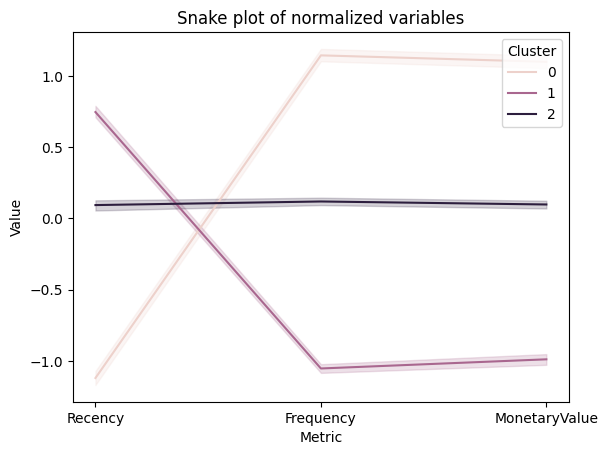

In [16]:
# Add the plot title
plt.title('Snake plot of normalized variables')

# Add the x axis label
plt.xlabel('Metric')

# Add the y axis label
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot(x="Metric", y="Value", hue='Cluster', data=datamart_melt)
plt.show()

## 0.4.10 Calculate relative importance of each attribute

In [17]:
# Calculate average RFM values for each cluster
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = datamart_rfm.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1


In [18]:
# Print relative importance scores rounded to 2 decimals
print(relative_imp.round(2))

         Recency  Frequency  MonetaryValue
Cluster                                   
0          -0.82       1.68           1.83
1           0.84      -0.84          -0.86
2          -0.15      -0.34          -0.42


## 0.4.11 Plot relative importance heatmap

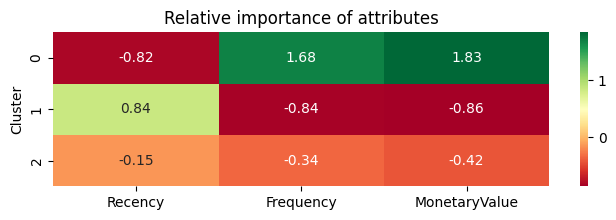

In [19]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 2))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

## 0.4.13 Pre-process data

In [20]:
datamart_rfmt = pd.read_csv(path.data_raw_dir("datamart_rfmt.csv"), sep=',', index_col='CustomerID')
datamart_rfmt.head()

,Recency,Frequency,MonetaryValue,Tenure
CustomerID,,,,
12747,3,25,948.70,362
12748,1,888,7046.16,365
12749,4,37,813.45,214
12820,4,17,268.02,327
12822,71,9,146.15,88


In [21]:
# Apply log transformation
datamart_rfmt_log = np.log(datamart_rfmt)

# Initialize StandardScaler and fit it 
scaler = StandardScaler(); scaler.fit(datamart_rfmt_log)

# Transform and store the scaled data as datamart_rfmt_normalized
datamart_rfmt_normalized = scaler.transform(datamart_rfmt_log)

## 0.4.14 Calculate and plot sum of squared errors

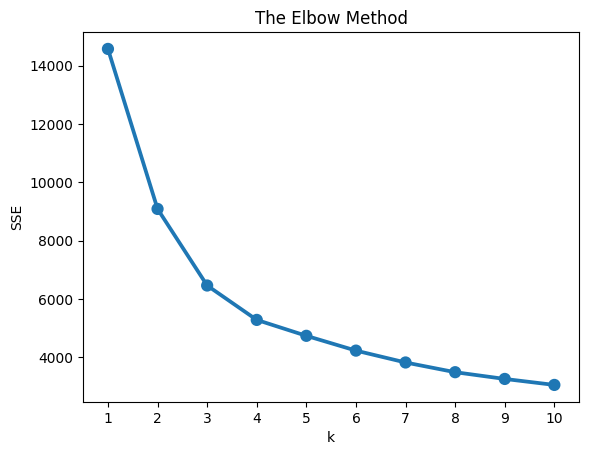

In [22]:
sse = {}

# Fit KMeans and calculate SSE for each k between 1 and 10
for k in range(1, 11):
  
    # Initialize KMeans with k clusters and fit it 
    kmeans = KMeans(n_clusters=k, random_state=1).fit(datamart_rfmt_normalized)
    
    # Assign sum of squared distances to k element of the sse dictionary
    sse[k] = kmeans.inertia_  

# Add the plot title, x and y axis labels
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')

# Plot SSE values for each k stored as keys in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

## 0.4.15 Build 4-cluster solution

In [23]:
# Initialize KMeans
kmeans = KMeans(n_clusters=4, random_state=1)

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_rfmt_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

## 0.4.16 Analyze the segments

In [24]:
# Create a new DataFrame by adding a cluster label column to datamart_rfmt
datamart_rfmt_k4 = datamart_rfmt.assign(Cluster=cluster_labels)

# Group by cluster
grouped = datamart_rfmt_k4.groupby(['Cluster'])

# Calculate average RFMT values and segment sizes for each cluster
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
    'Tenure': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue Tenure      
           mean      mean          mean   mean count
Cluster                                             
0          13.5      53.7        1142.8  279.6   777
1          33.0       7.2         101.0   45.2   750
2          89.0      15.0         276.7  247.5  1204
3         205.0       3.3          58.7  222.8   912

In [25]:
# Create a pandas DataFrame
datamart_rfmt_normalized = pd.DataFrame(datamart_rfmt_normalized, index=datamart_rfmt.index, columns=datamart_rfmt.columns)
datamart_rfmt_normalized = datamart_rfmt_normalized.assign(Cluster=cluster_labels)
datamart_rfmt_normalized.head()

,Recency,Frequency,MonetaryValue,Tenure,Cluster
CustomerID,,,,,
12747,-2.002202,0.865157,1.464940,0.919695,0
12748,-2.814518,3.815272,2.994692,0.928750,0
12749,-1.789490,1.189117,1.347598,0.342906,0
12820,-1.789490,0.546468,0.500595,0.808122,0
12822,0.337315,0.020925,0.037943,-0.632151,2


In [26]:
# Melt the normalized dataset and reset the index
datamart_melt = pd.melt(datamart_rfmt_normalized.reset_index(), 
                        
# Assign CustomerID and Cluster as ID variables
                    id_vars=['CustomerID', 'Cluster'],

# Assign RFM values as value variables
                    value_vars=['Recency', 'Frequency', 'MonetaryValue', 'Tenure'],
                        
# Name the variable and value
                    var_name='Metric', value_name='Value'
					)
datamart_melt.head() 

,CustomerID,Cluster,Metric,Value
0,12747,0,Recency,-2.002202
1,12748,0,Recency,-2.814518
2,12749,0,Recency,-1.789490
3,12820,0,Recency,-1.789490
4,12822,2,Recency,0.337315


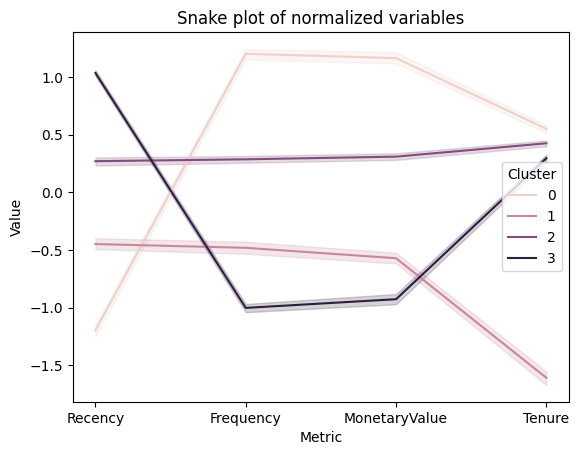

In [27]:
# Add the plot title
plt.title('Snake plot of normalized variables')

# Add the x axis label
plt.xlabel('Metric')

# Add the y axis label
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot(x="Metric", y="Value", hue='Cluster', data=datamart_melt)
plt.show()

In [28]:
print('ok_')

ok_
